In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import PIL
from PIL import Image, ImageOps
from keras.preprocessing.image import img_to_array

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [181]:
(X_train, y_train), (_, _) = mnist.load_data()
# Configure input
X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1) why?
# reverse color
X_train_inv = -(X_train.astype(np.float32))
# X_train = np.expand_dims(X_train, axis=3)
#y_train = y_train.reshape(-1, 1)

In [182]:
def to_255(X_train):
    return np.array(X_train).astype(np.float32)*127.5+ 127.5

In [176]:
def gen_image(arr):
    h, w = arr.shape[0], arr.shape[1]
    two_d = (np.reshape(arr, (h, w)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [177]:
def plot_dist(arr):
    n, m = arr.shape[0], arr.shape[1]
    flat = arr.reshape(np.prod(arr.shape))
    plt.hist(flat)

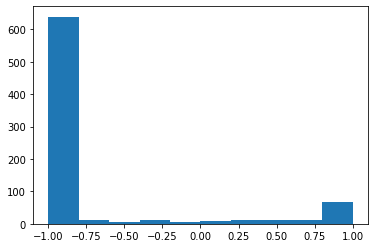

In [183]:
plot_dist(X_train[0])

In [185]:
X_dict = {}
for i in range(10):
    X_dict[i] = X_train[y_train==i]

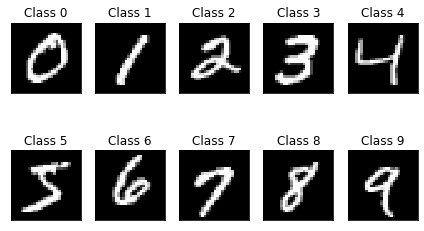

In [186]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_dict[i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

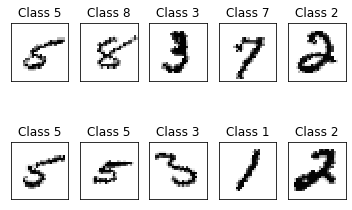

In [187]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    id = np.random.randint(0, 1000)
    #r = 18 * np.random.randint(-10, 10)
    sample = gen_image(X_train_inv[id])#.rotate(r)
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Class %d" % (y_train[id]))
    plt.xticks([])
    plt.yticks([])

In [268]:
# dotated data for each sample (8 rotation per img) -- DONE --
# X_rotated = {}
# num_rotation_per_img = 8
# angles = [45*i for i in range(num_rotation_per_img)]
# for i, img in enumerate(X_train):
#     img = gen_image(img)
#     label = y_train[i]
#     for angle in angles:
#         rotated_img = img.rotate(angle)
#         img_arr = np.asarray(rotated_img)
#         X_rotated[(i,angle)] = img_arr

In [10]:
# For pickleing
# import pickle
# with open('X_rotated.pickle', 'wb') as handle:
#     pickle.dump(X_rotated, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# To recover
# with open('X_rotated.pickle', 'rb') as handle:
#     X_rotated = pickle.load(handle)

In [ ]:
# Create & upload a file.
# uploaded = drive.CreateFile({'title': './MyDrive/X_rotated.pickle'})
# uploaded.SetContentFile('/content/X_rotated.pickle') 
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [75]:
# Rotated Image for 5  --DONE--
# X_5_rotated = []
# X_5_rotations = []
# num_rotation_per_img = 10
# for i, img in enumerate(X_dict[5]):
#     img = gen_image(img)
#     for j in range(num_rotation_per_img):
#         angle = np.random.randint(-90, 90)
#         rotated_img = img.rotate(angle)
#         img_arr = np.asarray(rotated_img)/255
#         X_5_rotated.append(img_arr)
#         X_5_rotations.append(angle)

In [83]:
# Rotated Image for 5 (easy)  --DONE--
# rotation limited only to same increments
# X_5_rotated_easy = []
# X_5_rotations_easy = []
# num_rotation_per_img = 10
# for i, img in enumerate(X_dict[5]): 
#     img = gen_image(img)
#     for j in range(num_rotation_per_img):
#         angle = (180/num_rotation_per_img)*j
#         rotated_img = img.rotate(angle)
#         img_arr = np.asarray(rotated_img)
#         X_5_rotated_easy.append(img_arr)
#         X_5_rotations_easy.append(angle)

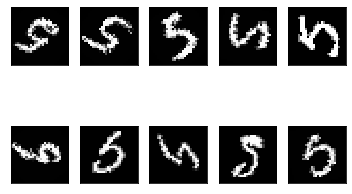

In [70]:
# fig = plt.figure()
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     id = np.random.randint(0, len(X_5_rotated_easy))
#     plt.imshow(X_5_rotated_easy[id], cmap='gray', interpolation='none')
#     #plt.title("angle %d" % (X_5_rotations[id]))
#     plt.xticks([])
#     plt.yticks([])

In [23]:
# # For pickleing
#import pickle
# with open('X_5_rotated_easy.pickle', 'wb') as handle:
#     pickle.dump(X_5_rotated_easy, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/MyDrive/X_5_rotated_easy.pickle', 'rb') as handle:
#     X_5_rotated_easy= pickle.load(handle)

In [12]:
# Generate samples that are randomly flipped color
X_inv_labels = [] #np.array([1 if np.random.rand() >0.5 else 0 for _ in range(len(y_train))])
X_inv = []
for i in range(len(X_train)):
    #plt.subplot(2, 5, i+1)
    if np.random.rand() > 0.5:
        X_inv.append(X_train[i])
        # plt.imshow(gen_image(X_inv[-1]), cmap='gray')
        # plt.xticks([])
        # plt.yticks([])
        X_inv_labels.append(0)
    else:
        X_inv.append(X_train_inv[i])
        # plt.imshow(gen_image(X_inv[-1]), cmap='gray')
        X_inv_labels.append(1)
        # plt.xticks([])
        # plt.yticks([])

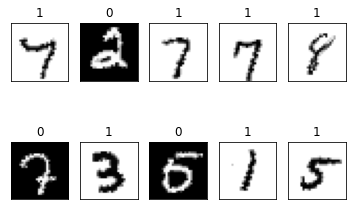

In [188]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    id = np.random.randint(0, len(X_inv))
    plt.imshow(gen_image(X_inv[id]), cmap='gray')
    plt.title("%d" % (X_inv_labels[id]))
    plt.xticks([])
    plt.yticks([])

In [107]:
# with open('X_2', 'wb') as handle:
#     pickle.dump(X_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('X_inv_labels', 'wb') as handle:
#     pickle.dump(X_inv_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

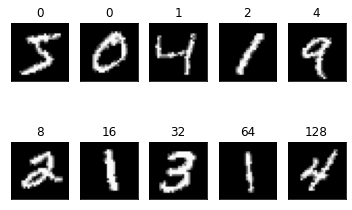

In [68]:
#Image.fromarray(X_2_bright[0])
from PIL import ImageFilter
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = X_train[i]
    img = gen_image(img)
    #img = img.filter(ImageFilter.GaussianBlur(radius=i/10))
    #id = np.random.randint(0, len(X_inv))
    plt.imshow(img, cmap='gray')
    plt.title("%d" % (X_2_brightness[i]))
    plt.xticks([])
    plt.yticks([])

In [199]:
def scale(arr):
    '''from (0,1) to (-, 1)'''
    return np.array(arr)*1.5 -0.5

In [189]:
def rescale(arr):
    X = arr.reshape((28*28,))
    MAX = np.max(X)
    MIN = np.min(X)
    min = -1
    max = 1
    rescaled =  np.array((max-min)*(arr-MIN)/(MAX-MIN) + min).reshape((28, 28, 1))
    return rescaled

In [17]:
def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

In [18]:
cropped = gen_image(center_crop(X_train[5], 18, 18))
cropped.resize((28, 28))

In [190]:
def resize(img, factor):
    """
    factor: range(-10, 10)
    """
    desired_size = 28
    new_size = (desired_size+factor,desired_size+factor)
    im = img.resize(new_size)
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(im, padding)

img = gen_image(X_train[0])  
resize(img, 10)
#plot_dist(np.array(resize(img,-10)))

In [218]:
resize(gen_image(X_train[0]), -10)

In [221]:
# gradienting on size
#from PIL import ImageEnhance
(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1)
X_2_resized = []
X_2_resizing = []
cond_list = np.array([i*2 for i in range(-5, 6)])
X_2_train = X_train[y_train==2]
for i in range(len(X_2_train)):
    img = gen_image(X_2_train[i])
    for cond in cond_list:
        X_2_resized.append(np.array(resize(img,cond)))
        X_2_resizing.append(cond)

In [222]:
gen_image(X_2_resized[0])

In [219]:
# gradienting on size EASY
#from PIL import ImageEnhance
(X_train, y_train), (_, _) = mnist.load_data()
X_2_resized_EASY = []
X_2_resizing_EASY = []
cond_list = np.array([i*5 for i in range(-2, 3)])
X_2_train = X_train[y_train==2]
for i in range(len(X_2_train)):
    img = gen_image(X_2_train[i])
    for cond in cond_list:
        X_2_resized_EASY.append(np.array(resize(img,cond)))
        X_2_resizing_EASY.append(cond)

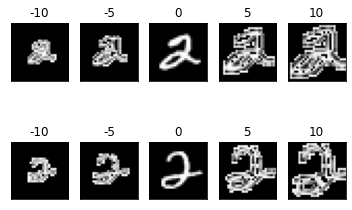

In [220]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    im = X_2_resized_EASY[i]
    img = gen_image(im)
    plt.imshow(img, cmap='gray')
    plt.title("%d" % (X_2_resizing_EASY[i]))
    plt.xticks([])
    plt.yticks([])

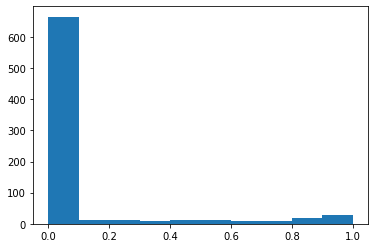

In [211]:
plot_dist(X_2_resized[2])

In [53]:
# import pickle
# with open('X_2_resized_EASY.pickle', 'wb') as handle:
#     pickle.dump(X_2_resized_EASY, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('X_2_resizingEASY.pickle', 'wb') as handle:
#     pickle.dump(X_2_resizing_EASY, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Blur

In [149]:
# gradienting on blur
#from PIL import ImageEnhance
from PIL import Image, ImageFilter 
X_2_blured= []
X_2_blurring = []
cond_list = np.array([i*0.45 for i in range(5)])
X_2_train = X_train[y_train==2]
for arr in X_2_train:
    img = gen_image(arr)
    for cond in cond_list:
        X_2_blured.append(np.array(img.filter(ImageFilter.GaussianBlur(radius = cond ))))
        X_2_blurring.append(cond)

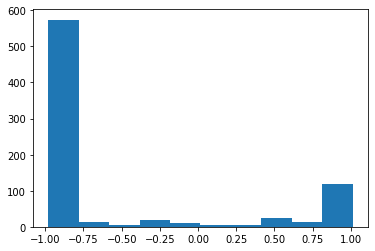

In [166]:
X_2_blured_adjusted = (np.array(X_2_blured).astype(np.float32) -126)/ 127.5
plot_dist(X_2_blured_adjusted[10])

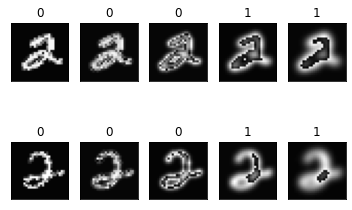

In [167]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    im = X_2_blured_adjusted[i]
    img = gen_image(im)
    plt.imshow(img, cmap='gray')
    plt.title("%d" % X_2_blurring[i])
    plt.xticks([])
    plt.yticks([])

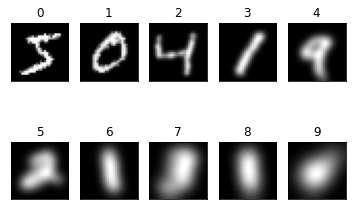

In [145]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    im = X_train[i]
    img = gen_image(im)
    img = img.filter(ImageFilter.GaussianBlur(radius=0.45*i))
    plt.imshow(img, cmap='gray')
    plt.title("%d" % i)
    plt.xticks([])
    plt.yticks([])

In [146]:
import pickle
with open('./drive/MyDrive/X_2_blurred.pickle', 'wb') as handle:
    pickle.dump(X_2_blured, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./drive/MyDrive/X_2_blurring.pickle', 'wb') as handle:
    pickle.dump(X_2_blurring, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
from PIL import ImageEnhance
# changing brightness
img = gen_image(X_2_train[0])
#image brightness enhancer
enhancer = ImageEnhance.Brightness(img)
factor = 0.2 # 1 gives original image
enhancer.enhance(factor)

In [88]:
def to_image(arr):
    h, w = arr.shape[0], arr.shape[1]
    two_d = np.reshape(arr, (h, w)).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [113]:
from PIL import ImageEnhance
#from PIL import Image, ImageFilter 
X_2_bright= []
X_2_brightness = []
cond_list = np.array([0.2, 0.4, 1, 3, 45])
X_2_train = X_train[y_train==2]
for arr in X_2_train:
    img = gen_image(arr)
    enhancer = ImageEnhance.Brightness(img)
    for i, cond in enumerate(cond_list):
        img_enhenced = enhancer.enhance(cond)
        X_2_bright.append(rescale(np.array(img_enhenced)))
        X_2_brightness.append(i)

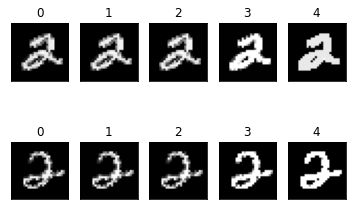

In [115]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    im = X_2_bright[i]
    img = gen_image(im)
    plt.imshow(img, cmap='gray')
    plt.title("%d" % X_2_brightness[i])
    plt.xticks([])
    plt.yticks([])

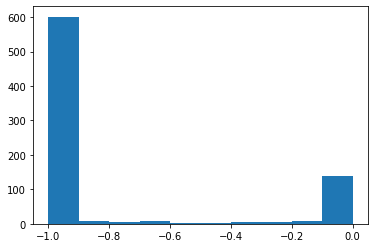

In [112]:
plot_dist(rescale(X_2_bright[3]))

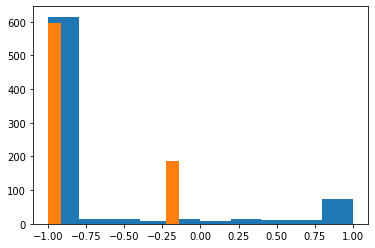

In [116]:
plot_dist(X_2_bright[0])
plot_dist(X_2_bright[4])

In [117]:
to_image(X_2_bright[0])

In [119]:
import pickle
with open('./drive/MyDrive/X_2_bright.pickle', 'wb') as handle:
    pickle.dump(X_2_bright, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./drive/MyDrive/X_2_brightness.pickle', 'wb') as handle:
    pickle.dump(X_2_brightness, handle, protocol=pickle.HIGHEST_PROTOCOL)